In [101]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination


In [102]:
# Load dataset
df = pd.read_csv("heart_disease.csv")

# Remove duplicates
df.drop_duplicates(inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)


In [103]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Normalize
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [104]:
# Discretize: convert continuous features into bins
df['age'] = pd.cut(df['age'], bins=3, labels=["young", "middle", "old"])
df['fbs'] = df['fbs'].astype(int)
df['target'] = df['target'].astype(int)
df['chol'] = pd.cut(df['chol'], bins=3, labels=["low", "medium", "high"])
df['thalach'] = pd.cut(df['thalach'], bins=3, labels=["low", "medium", "high"])


In [105]:

# Load and prepare your dataset...
# Then create the model:
model = DiscreteBayesianNetwork([
    ('age', 'fbs'),
    ('fbs', 'target'),
    ('target', 'chol'),
    ('target', 'thalach')
])
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Run inference
inference = VariableElimination(model)


In [106]:
infer = VariableElimination(model)

# 1. What is the probability of heart disease (target=1) given a middle-aged person?
q1 = infer.query(variables=['target'], evidence={'age': 'middle'})
print("P(target=1 | age=middle):\n", q1)

# 2. What is the cholesterol distribution given heart disease is present?
q2 = infer.query(variables=['chol'], evidence={'target': 1})
print("Cholesterol distribution | target=1:\n", q2)

# 3. What is the probability of heart disease given fbs=1 and age=old?
q3 = infer.query(variables=['target'], evidence={'fbs': 1, 'age': 'old'})
print("P(target | fbs=1, age=old):\n", q3)


P(target=1 | age=middle):
 +-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4578 |
+-----------+---------------+
| target(1) |        0.5422 |
+-----------+---------------+
Cholesterol distribution | target=1:
 +--------------+-------------+
| chol         |   phi(chol) |
+==============+=============+
| chol(high)   |      0.0061 |
+--------------+-------------+
| chol(low)    |      0.7927 |
+--------------+-------------+
| chol(medium) |      0.2012 |
+--------------+-------------+
P(target | fbs=1, age=old):
 +-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4889 |
+-----------+---------------+
| target(1) |        0.5111 |
+-----------+---------------+


In [107]:
inference = VariableElimination(model)


<h1>Testing the model</h1>

In [108]:
# Q1: What is the probability of heart disease (target=1) given age is 'middle'?

q1 = inference.query(variables=['target'], evidence={'age': 'middle'})
print("Q1: P(target | age='middle')\n", q1)

Q1: P(target | age='middle')
 +-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4578 |
+-----------+---------------+
| target(1) |        0.5422 |
+-----------+---------------+


In [109]:
# Q2: What is the cholesterol level distribution when heart disease is present (target=1)?
q2 = inference.query(variables=['chol'], evidence={'target': 1})
print("\nQ2: P(chol | target=1)\n", q2)



Q2: P(chol | target=1)
 +--------------+-------------+
| chol         |   phi(chol) |
+==============+=============+
| chol(high)   |      0.0061 |
+--------------+-------------+
| chol(low)    |      0.7927 |
+--------------+-------------+
| chol(medium) |      0.2012 |
+--------------+-------------+


In [110]:
#Q3: What is the probability of heart disease given fbs=1 and age='old'?

q3 = inference.query(variables=['target'], evidence={'fbs': 1, 'age': 'old'})
print("\nQ3: P(target | fbs=1, age='old')\n", q3)



Q3: P(target | fbs=1, age='old')
 +-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4889 |
+-----------+---------------+
| target(1) |        0.5111 |
+-----------+---------------+


In [111]:
 #Q4: What is the heart disease risk (target) for a person with high cholesterol and low thalach?

 q4 = inference.query(variables=['target'], evidence={'chol': 'high', 'thalach': 'low'})
print("\nQ4: P(target | chol='high', thalach='low')\n", q4)



Q4: P(target | chol='high', thalach='low')
 +-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.0000 |
+-----------+---------------+
| target(1) |        1.0000 |
+-----------+---------------+


<h1>Visuals</h1>

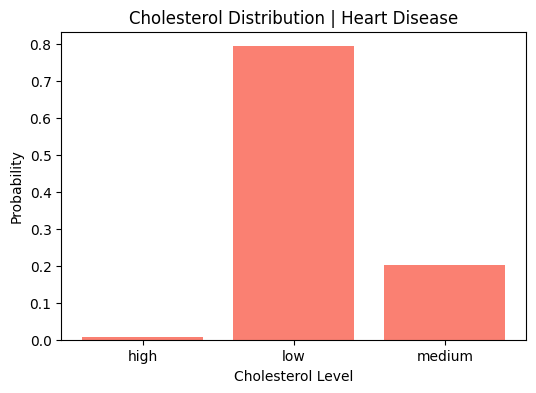

In [112]:
 #Cholesterol Distribution Given Heart Disease

q_chol = inference.query(variables=['chol'], evidence={'target': 1})
q_chol_vals = q_chol.values

plt.figure(figsize=(6,4))
plt.bar(q_chol.state_names['chol'], q_chol_vals, color='salmon')
plt.title("Cholesterol Distribution | Heart Disease")
plt.xlabel("Cholesterol Level")
plt.ylabel("Probability")
plt.show()


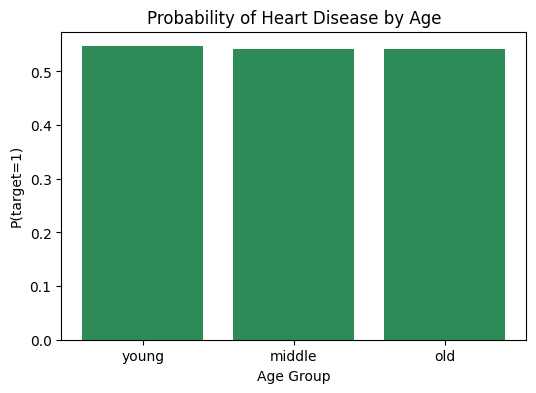

In [113]:
#Heart Disease Probability by Age Group

age_groups = ['young', 'middle', 'old']
probs = []

for age in age_groups:
    q = inference.query(variables=['target'], evidence={'age': age})
    probs.append(q.values[1])  # target=1

plt.figure(figsize=(6,4))
plt.bar(age_groups, probs, color='seagreen')
plt.title("Probability of Heart Disease by Age")
plt.xlabel("Age Group")
plt.ylabel("P(target=1)")
plt.show()


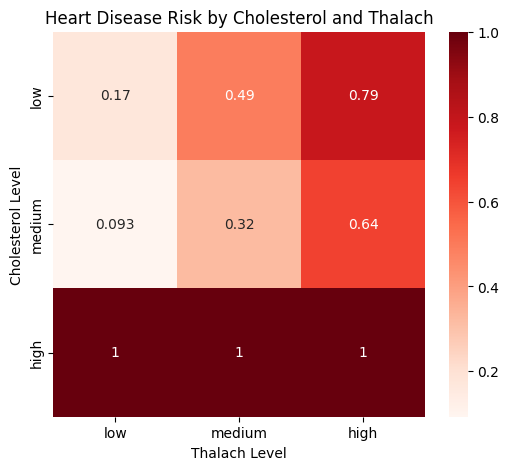

In [114]:
#Heart Disease Risk Given Cholesterol & Thalach

import seaborn as sns
import numpy as np

chol_levels = ['low', 'medium', 'high']
thalach_levels = ['low', 'medium', 'high']
risk_matrix = []

for ch in chol_levels:
    row = []
    for th in thalach_levels:
        q = inference.query(variables=['target'], evidence={'chol': ch, 'thalach': th})
        row.append(q.values[1])  # P(target=1)
    risk_matrix.append(row)

plt.figure(figsize=(6, 5))
sns.heatmap(risk_matrix, annot=True, cmap="Reds", xticklabels=thalach_levels, yticklabels=chol_levels)
plt.title("Heart Disease Risk by Cholesterol and Thalach")
plt.xlabel("Thalach Level")
plt.ylabel("Cholesterol Level")
plt.show()
